${\large \textbf{Finding Eclipse}}$

Our problem is to expect solar and lunar eclipses that will occur in the next 1 year. Consider the following initial conditions.

$-{\scriptsize \textbf{velAndPos}}$: $6\cdot 1$ array containing the velocities and positions of the Sun, Mercury, Venus, Earth, Earth's Moon, Mars, Jupiter, Saturn, Uranus, Neptune, and Pluto. The positions and velocities are corresponding to 29th May 2019, at 9 am.

$-{\scriptsize \textbf{bodyMass}}$: $11\cdot 1$ array containing mass of each body.

In [1]:
from scipy import io
import pandas as pd

mat = io.loadmat('solarSimData.mat')

mass= mat['bodyMass']
velAndPos = mat['velAndPos']

The motion of $11$bodies can be described as the system of ODEs,

$$ \begin{equation*}
\frac{d}{dt}   \begin{bmatrix}
v^b \\
x^b
\end{bmatrix} = \begin{bmatrix}
\sum_{p=1,p \neq b}^{11}g\left(x^b-x^p,M^p\right)\\
v^b
\end{bmatrix},
\end{equation*}$$

for $b = 1,...11$. Here $x^b \in \mathbb{R}^3, v^b \in \mathbb{R}^3,M^p$ are positions, velocities and mass of $11$ bodies, respectively.
The function ${\scriptsize \textbf{nBodyf}}$ compute the right-hand side of the system of ODEs. This function internally use the implementation of the function ${\scriptsize \textbf{gravAccf}}$, which returns gravitational acceleration.

In [2]:
import numpy as np

#G is gravitational constant
def gravAccf(x, G, M):
    return -G*M/(np.linalg.norm(x)**3)*x

def nBodyF(t, solVec, mass):
    G = 4*(np.pi)**2
    N = np.size(mass)
    solVec = np.reshape(solVec, (N,6)).T
    F = np.zeros(np.shape(solVec))
    for b in range(0,N):
        for p in range(0,N):
            if b != p:
                F[0:3,[b]] = F[0:3,[b]]-gravAccf(solVec[3:6,[b]]-solVec[3:6,[p]],G,mass[p])
    F = -F
    for b in range(0,N):   
        F[3:6,[b]]=solVec[0:3,[b]]
    func = np.reshape(F.T,(np.size(solVec),1))
    return func

The given problem can be written as an initial-valued problem

$$\frac{dy}{dt} = f(t,y), t\in [t_0,T],$$

$$y(t_0)=y_0=\begin{bmatrix}
v_0\\
x_0
\end{bmatrix}.$$

We wish to find an approximation $u_n \approx y(t_n)$, for $t_n = t_0+nh$. We consider the $\beta$-method for solving IVPs, which is given by 

$$u_0 = y_0, u_{n+1}= u_{n}+hf(t_{n+\beta}, (1-\beta)u_n+\beta u_{n+1}),$$

where $t_{n+\beta}=t+\beta h$ and $\beta \in \mathbb{R}.$ If $\beta = 0$, the $\beta$-method is explicit. However, for $\beta \neq 0$, we need to solve implicit method. Hence, in each step, we solve 

$$F(u_{n+1})=0, F(x)= x-u_n-hf(t_{n+\beta}, (1-\beta)u_n+\beta x).$$

The function ${\scriptsize \textbf{Betamethod}}$ internally uses the implementation of the Newton method when $\beta \neq 0$.

In [3]:
def Betamethod(f, tRange, u0, df, beta, h):
    N = len(u0)
    solArray = u0
    tArray = np.arange(tRange[0], tRange[-1]+h, h)
    #explicit methond
    if beta == 0:
        for k in range(0, len(tArray)-1):
            u0 = u0+h*f(tArray[k],u0)
            solArray = np.append(solArray, u0,1)
    #implicit method        
    else:
        for k in range(0, len(tArray)-1): 
            def F(x):
                return x-u0-h*f(tArray[k]+h*beta, (1-beta)*u0+beta*x)
            def Df(x):
                return np.eye(N)-h*beta*df(tArray[k]+h*beta,(1-beta)*u0+beta*x)   
            [success, xHist, xfin, errEst] = newton(F, Df, u0, tol=10**(-12), maxIt=50)
            u0=xfin
            solArray = np.append(solArray, xfin, 1)
            #terminate if Newton's method has failed
            if success == 0:
                print('newton method failed')
                break
                
    return[tArray, solArray]

Newton's method update $x$ in each iteration as follows,

$$x_{n+1} = x_n -J_F (x_n)^{-1} \cdot F(x_n).$$

If the initial guess is close enough to the real root, it converges to the root of $F.$

In [4]:
def newton(f, df, x0, tol, maxIt):
    
    success = 0
    
    def G(x):
        return x-np.linalg.solve(df(x),f(x))
    
    xHist = x0
    errEst = []
    
    for k in range(0,maxIt):
        xHist = np.append(xHist, G(xHist[:,[k]]),1)
        errest = np.linalg.norm(xHist[:,[k+1]]-xHist[:,[k]])
        errEst = np.append(errEst, errest)
        if errest <tol:
            success = 1
            break
            
    xfin = xHist[:,[-1]]
    
    return [success, xHist, xfin, errEst]

In [5]:
#jacobian of gravitational constant
def gravAccJac(x, G, M):
    return G*M/(np.linalg.norm(x)**3)*(-np.eye(3)+3/(np.linalg.norm(x)**2)*(x@(x.T)))

def rangeVel(i):
    vel = np.arange(6*(i-1),6*(i-1)+3,1)
    return vel

def rangePos(i):
    pos= np.arange(6*(i-1)+3,6*i,1)
    return pos

def nBodyJac(t, solVec, mass):
    G = 4*np.pi**2
    N = np.size(mass)
    jacF = np.zeros((np.size(solVec),np.size(solVec)))
    for b in range(1,N+1):
        for p in range (1,N+1):
            if b != p:
                jacg= gravAccJac(solVec[rangePos(p)]-solVec[rangePos(b)],G,mass[p-1])
                jacF[rangeVel(b)[:,None],rangePos(p)] = jacF[rangeVel(b)[:,None],rangePos(p)]+jacg
                jacF[rangeVel(b)[:,None],rangePos(b)] = jacF[rangeVel(b)[:,None],rangePos(b)]-jacg
        jacF[rangePos(b)[:,None],rangeVel(b)]= np.eye(3)
    return jacF

In [6]:
#We use a time step of 2 hours and beta = 1/2

h = 2/(365*24)
beta = 1/2
tRange = [0,1]

def f(t,y):
    return nBodyF(t,y,mass)

def df(t,y):
    return nBodyJac(t,y,mass)

u0 = np.reshape(velAndPos.T,(66,1))

[tArray, solArray] = Betamethod(f, tRange, u0, df, beta, h)

We can plot the positions of the approximate orbits in the x,y plane.

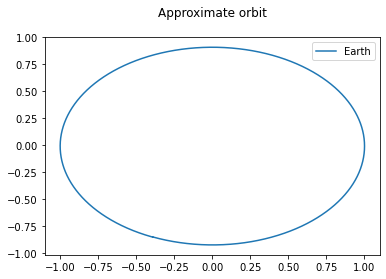

In [7]:
import matplotlib.pyplot as plt
plt.title("Approximate orbit\n")
plt.plot(solArray[21,:],solArray[22,:],label='Earth')
plt.legend()
plt.show()

The occurrence of a solar eclipse and a lunar eclipse corresponds to $\alpha(t)=-1$ and $\alpha(t)=1$, respectively, where

$$\alpha(t)= \frac{dme(t)\cdot dms(t)}{||dme(t)||_2||dms(t)||_2}.$$

Here dme is the distance between Earth's Moon and Earth, and dms is the distance between Earth's Moon and the sun. We find solar eclipses by computing a local minimum of $\alpha_n=\alpha(t_n)$ where additionally $|\alpha_n+1|<3\cdot 10^{-4}$, lunar eclipses by computing a local maximum of $\alpha_n$ which satisfies $|\alpha_n=1|< 3\cdot 10^{-4}$.

In [8]:
size_t = np.size(tArray)
dme = np.zeros((3,size_t))
dms = np.zeros((3,size_t))
alpha = np.zeros(size_t)

for t in range(0,np.size(tArray)):
    dme= solArray[27:30,[t]]-solArray[21:24,[t]]
    dms= solArray[27:30,[t]]-solArray[3:6,[t]]
    alpha[t] = (dme.T@dms)/((np.linalg.norm(dme,2)*np.linalg.norm(dms,2))) 

In [9]:
def findlocalMaxima(xvals, yvals):
    
    N = np.size(yvals)
    xmax = []
    ymax = []
    
    for t in range(1,N-1):
        if  yvals[t]>yvals[t-1]:
             if yvals[t] >yvals[t+1]:
                X = [xvals[t-1],xvals[t],xvals[t+1]]
                Y = [yvals[t-1], yvals[t], yvals[t+1]]
                c = np.polyfit(X,Y,2)
                x_max = -c[1]/(2*c[0])
                y_max = c[0]*x_max**2+c[1]*x_max+c[2]
                xmax = np.append(xmax, x_max)
                ymax = np.append(ymax, y_max)
                
    return [xmax, ymax]

In [10]:
import datetime
start = datetime.datetime(2019,5,29,9,0,0)

[xmax, ymax] = findlocalMaxima(tArray,alpha)

print("Lunar and solar eclipses will occur on:\n")

for i in range(0, np.size(ymax)):
    if abs(ymax[i]-1) <3*10**(-4):
        lunar = start +datetime.timedelta(seconds=round(365*24*3600*xmax[i]))
        print(lunar,"(lunar eclipse)")
        
[xmax, ymax] = findlocalMaxima(tArray,-alpha)

for i in range(0,np.size(ymax)):
    if abs(-ymax[i]+1) <3*10**(-4):
        solar = start +datetime.timedelta(seconds=round(365*24*3600*xmax[i]))
        print(solar,"(solar eclipse)")

Lunar and solar eclipses will occur on:

2019-07-16 20:18:26 (lunar eclipse)
2020-01-10 13:47:54 (lunar eclipse)
2019-07-02 18:36:54 (solar eclipse)
2019-12-26 00:11:03 (solar eclipse)
